In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [3]:
location = '/Users/emmanuels/Downloads/creditcard.csv'
dat = pd.read_csv(location)

In [4]:
dat.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [5]:
#summary statistics
ax = dat.groupby('Class').size().transform(lambda x: (x/sum(x)*100)).plot.bar()
for a in ax.patches:
    ax.text(a.get_x()+.06,a.get_height()+.5,\
           str('{}%'.format(round(a.get_height(),3))),fontsize=15,
              color='black')
old = [0,1]
new = ['Normal','Fraudulent']
ax.set_xticks(old)
ax.set_xticklabels(new,rotation=0,fontsize=15)

[Text(0, 0, 'Normal'), Text(0, 0, 'Fraudulent')]

In [6]:
print('Total of normal transactions is:',sum(dat['Class'] == 0))
print('Total of normal transactions is:',sum(dat['Class'] == 1))

Total of normal transactions is: 284315
Total of normal transactions is: 492


In [7]:
#check if any na values in any of the columns
dat.columns[dat.isnull().any()]

Index([], dtype='object')

In [8]:
#checking spending patterns

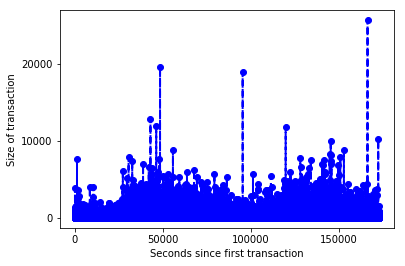

In [9]:
import matplotlib.pyplot as plt
plt.plot( 'Time', 'Amount', data=dat, marker='o', color='blue',
                  linewidth=2, linestyle='dashed', label="toto")
plt.xlabel('Seconds since first transaction')
plt.ylabel('Size of transaction')
plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams["font.size"] = "20"

In [10]:
#transactions by the hour
#divide by 3600 to get hours


In [11]:
dat['Hours'] = dat['Time']/3600

In [12]:
dat['Hours'] = pd.cut(dat['Hours'], bins=48, labels=range(48))

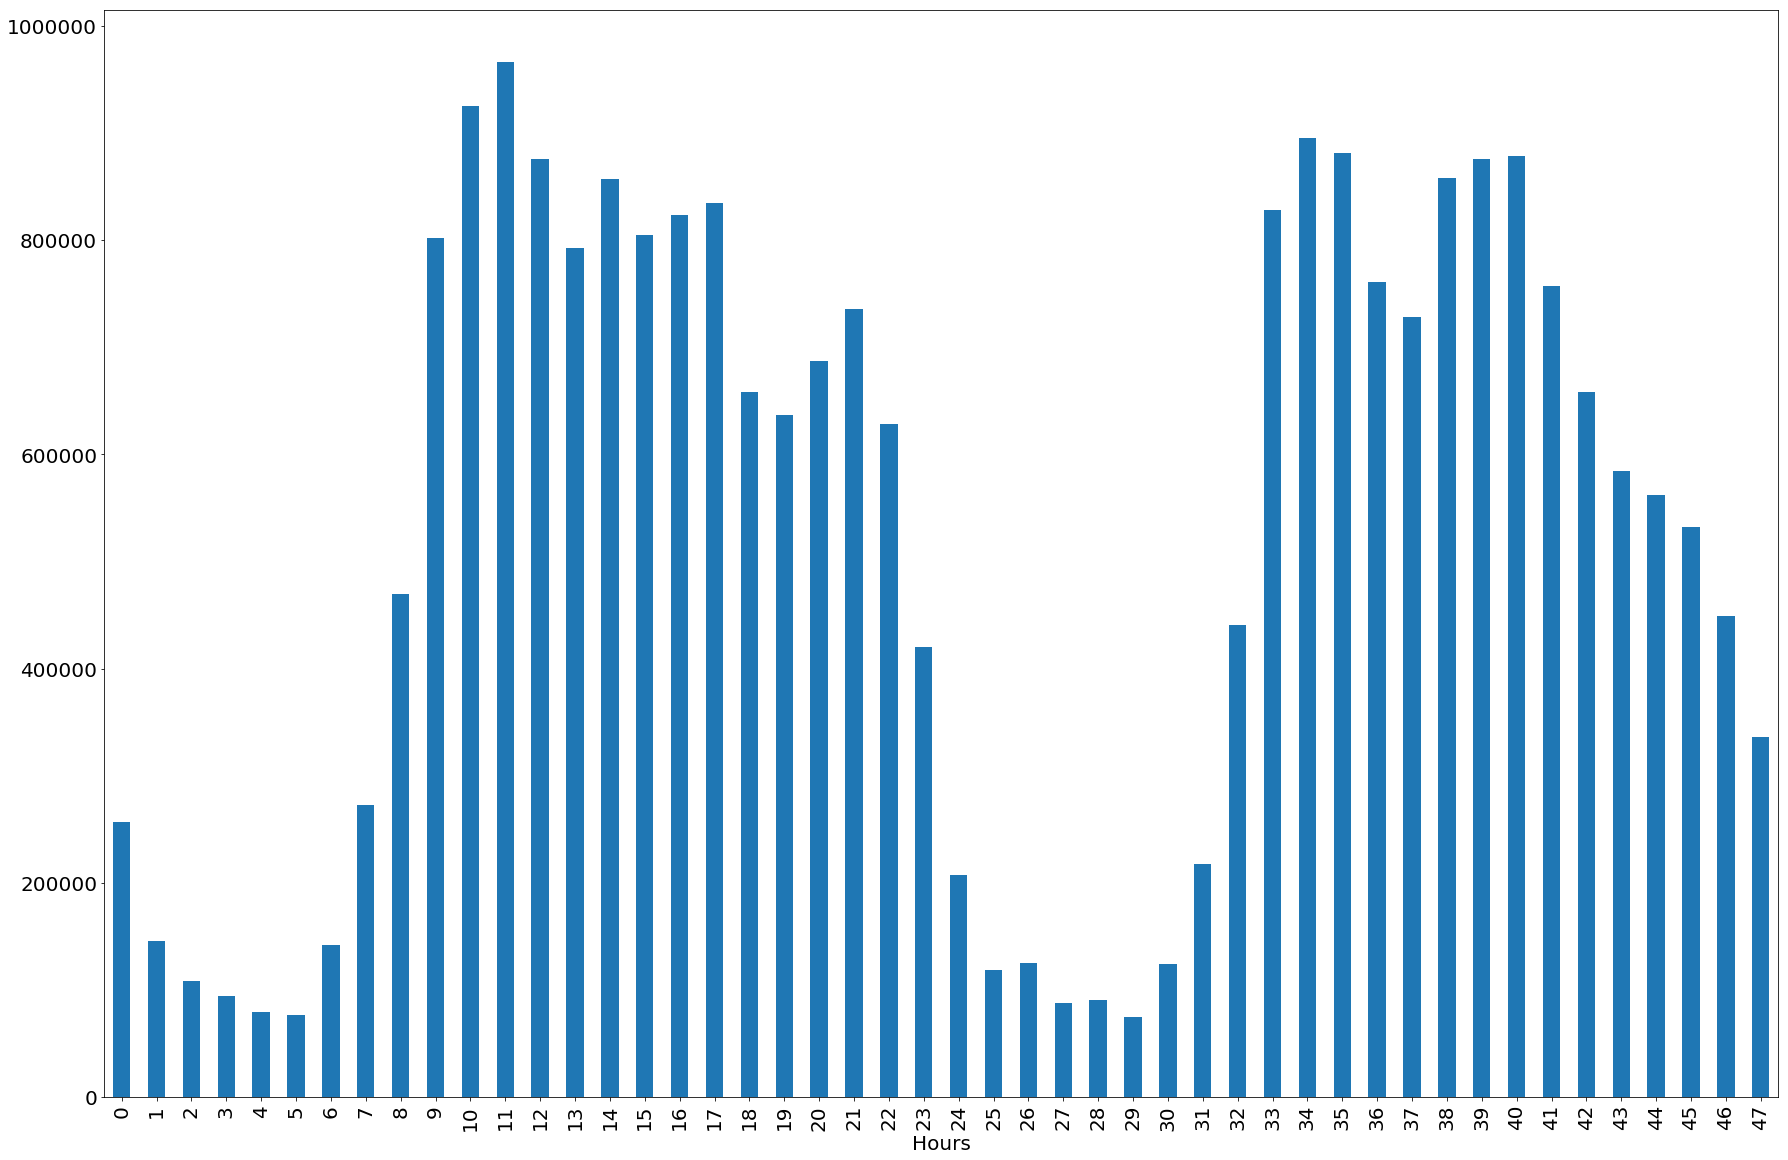

In [13]:
#number transactions by the hour
dat.groupby('Hours')['Amount'].sum().plot(kind="bar")

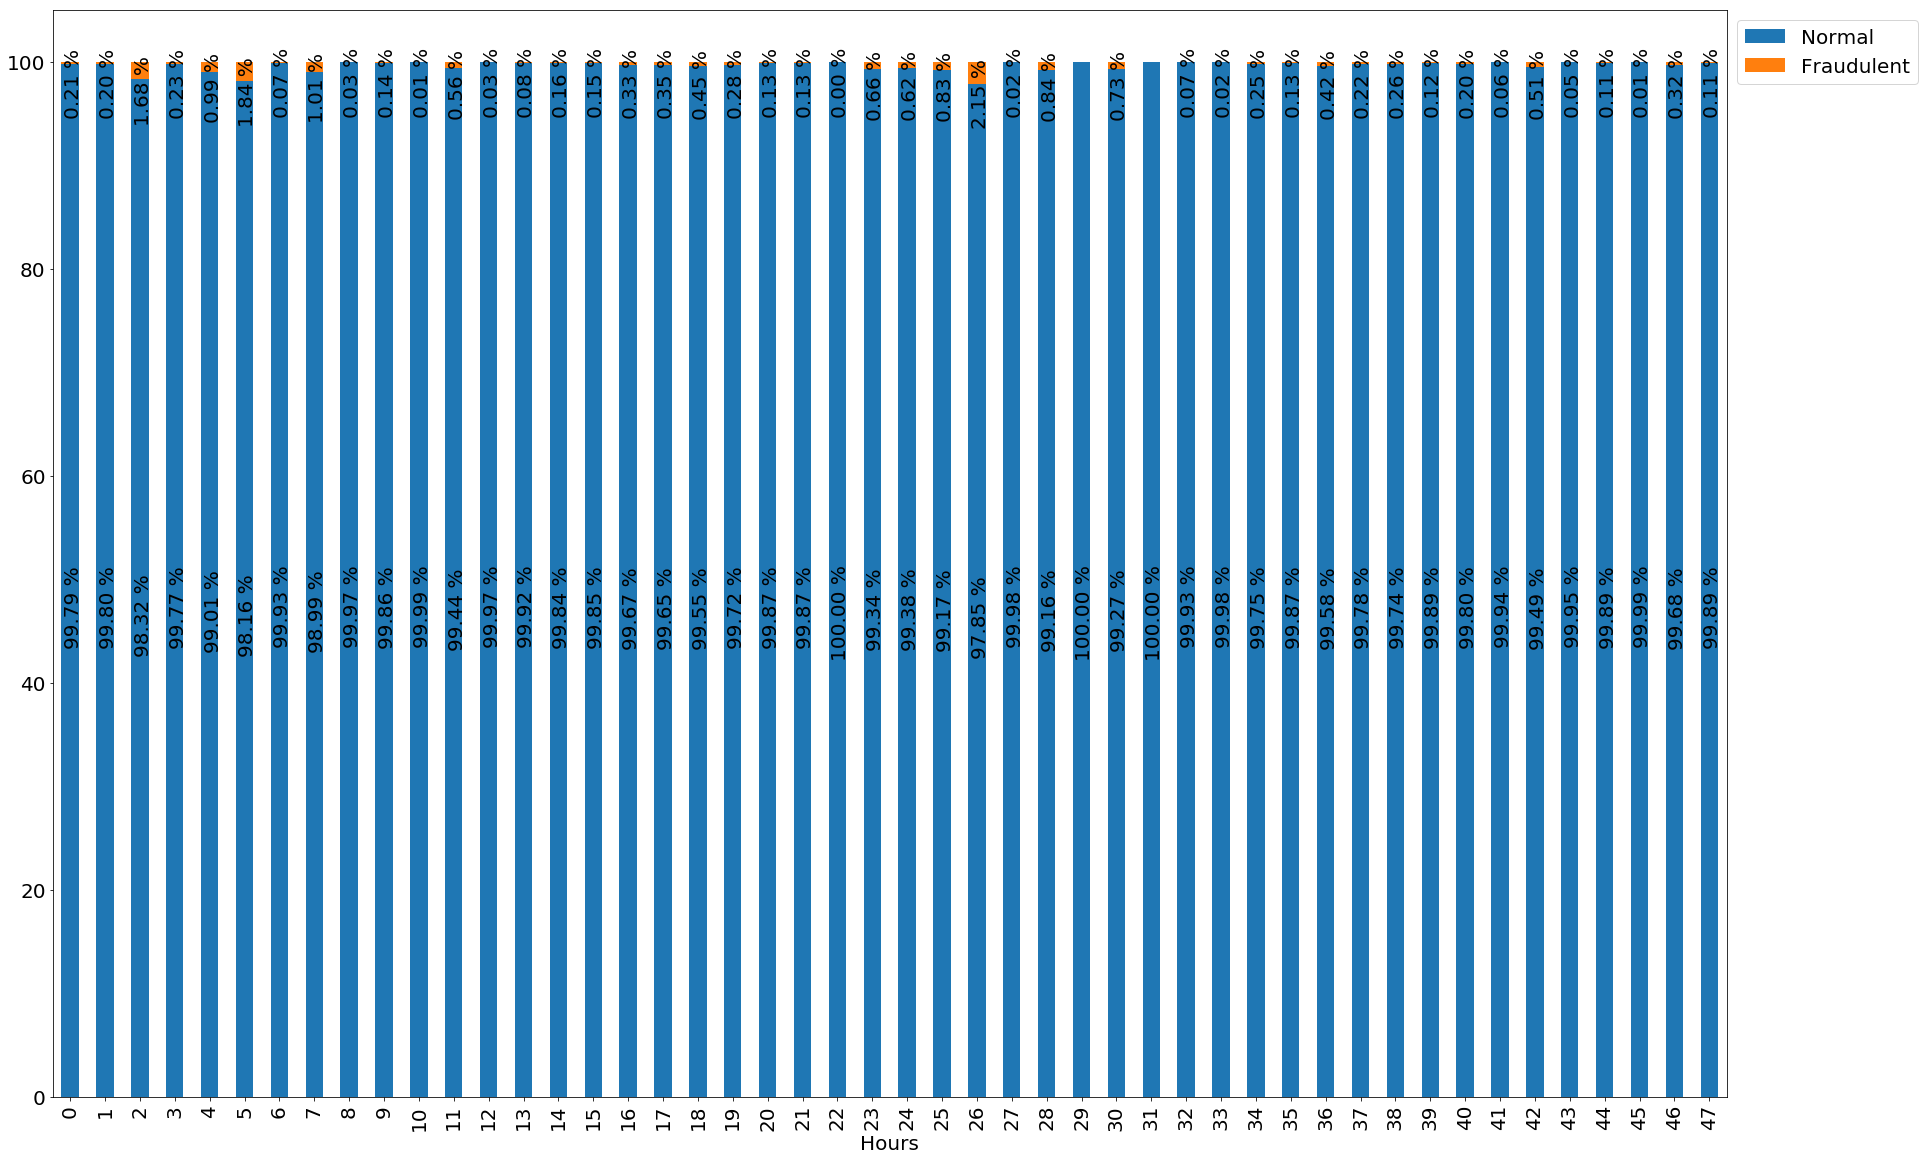

In [14]:
#visualising amount spent per hour by class
dat_grouped = dat.groupby(['Hours','Class'])['Amount'].sum()
ax_three = dat_grouped.groupby(level=0).apply(lambda x:round(100*x/x.sum(),3)).unstack().plot.bar(stacked=True)
for i in ax_three.patches:
    width,height=i.get_width(),i.get_height()
    x,y = i.get_xy()
    horiz_offset=1
    vert_offset=1
    labels = ['Normal','Fraudulent']
    ax_three.legend(bbox_to_anchor=(horiz_offset,vert_offset),labels=labels)
    if height > 0:
        ax_three.annotate('{:.2f} %'.format(height),
                         (i.get_x()+.15*width,
                         i.get_y()+.5*height),
        rotation=90)

In [15]:
a= dat.groupby(['Hours','Class'])['Amount'].sum()
b=pd.DataFrame(a.groupby(level=0).apply(lambda x:round(100*x/x.sum(),3)).unstack())
b=b.reset_index()
b.columns = ['Hours','Normal','Fraudulent']
dat = pd.merge(dat,b[['Hours','Fraudulent']],on='Hours', how='inner')

## Notes
- I think there is a correlation between the volume of transactions made in a given hour and fraudulent transactions- lower = higher propensity for transaction to be fraudulent 
- I want to create a column that shows the total number of transactions made in a given hour

In [16]:
#checking correlation between hour from initial transaction and likelihood to be fraudulent
dat['transaction volume in hour'] = dat.groupby('Hours')['Amount'].transform(sum)


## Recursive Feature Elimination
- datasets are high dimensional- contain many features or attributes
- Not all features contribute to the prediction variable, removing features of lower importance can increase accuracy and reduce model complexity. This can also reduce overall training time
- recursively removes features and builds a model using the remaining attributes
- first the model is fit on the data, then drop features with the lowest coeffecients, pthen fit on remaining features and repeat until we have the necesary number of features or criteria is fulfilled
- uses accuracy metric to rank the feature according to their importance

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
log_reg = LogisticRegression(penalty='l1')

## principal components analysis
- finding which projection between 2 axes makes the most sensre- projection of 3 dimensions to 2

In [18]:
dat['Fraudulent'] = dat['Fraudulent'].fillna(0)

In [19]:
dat.columns[dat.isnull().any()]


Index([], dtype='object')

In [20]:
y = dat['Class']
X = dat.drop(['Class','transaction volume in hour'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=100)

In [21]:
log_reg.fit(X_train,y_train)
#predicting with models
predicts = log_reg.predict(X_test)
#f1 score is harmonic mean of recall and precision score
confusion_matrix(y_test,predicts)

/Users/emmanuels/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[85277,    24],
       [   47,    95]])

In [22]:
print(classification_report(y_test,predicts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.80      0.67      0.73       142

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.90      0.83      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [23]:
cols = list(X.columns)
a = log_reg.coef_
pd.Series(data=a.flatten(), index=cols)

Time          0.000008
V1            0.177749
V2           -0.102066
V3           -0.092460
V4            0.625117
V5            0.099376
V6           -0.083124
V7           -0.015565
V8           -0.216365
V9           -0.533832
V10          -0.742636
V11          -0.223047
V12           0.169058
V13          -0.485487
V14          -0.762163
V15          -0.148594
V16          -0.155488
V17          -0.201367
V18           0.032316
V19           0.112970
V20          -0.455119
V21           0.391642
V22           0.514165
V23          -0.066426
V24           0.082470
V25          -0.137926
V26           0.000000
V27          -0.655180
V28          -0.282881
Amount        0.000478
Hours        -0.047882
Fraudulent    1.610253
dtype: float64

## Feature ranking
- need to find the optimum number of features for which we will get the highest accuracy
- Unbalanced Classification - fewer cases in which there is fraud compared to no fraud...very little chance that model will predict false negative - accuracy not the right metric to assess model fit
- we can look at the F1 score
- recall is the ratio of true positives and sum of true positives and false negatives- tells us how well our model correctly classifies positives cases out of all actual positive cases
- precision is the ratio of true positives and sum of true positives and false negatives - tells how much model correctly predicts positive cases out of cases which model predicts positive
- optimising based on accuracy, optimises accuracy to the detriment of the algorithms ability to predict fraudulent transactions- need to optimise for a better metric like f1 score

## Interpreting coefficients
- looking for proportions
- can convert log odds into proportions using the inverse logit function

In [24]:
from sklearn.feature_selection import RFECV
selector = RFECV(log_reg,step=2,cv=5,scoring='f1_macro')
selector = selector.fit(X,y)

/Users/emmanuels/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/emmanuels/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/emmanuels/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/emmanuels/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/emmanuels/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [25]:
selector.support_

array([False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True])

In [26]:
#eliminating features according to the recursive feature elimination with cross validation
cols = list(X.columns)
temp =pd.Series(selector.support_,index=cols)
selected_features = temp[temp==True].index
selected_features

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V19', 'V20', 'V21', 'V22', 'V23',
       'V24', 'V25', 'V27', 'V28', 'Fraudulent'],
      dtype='object')

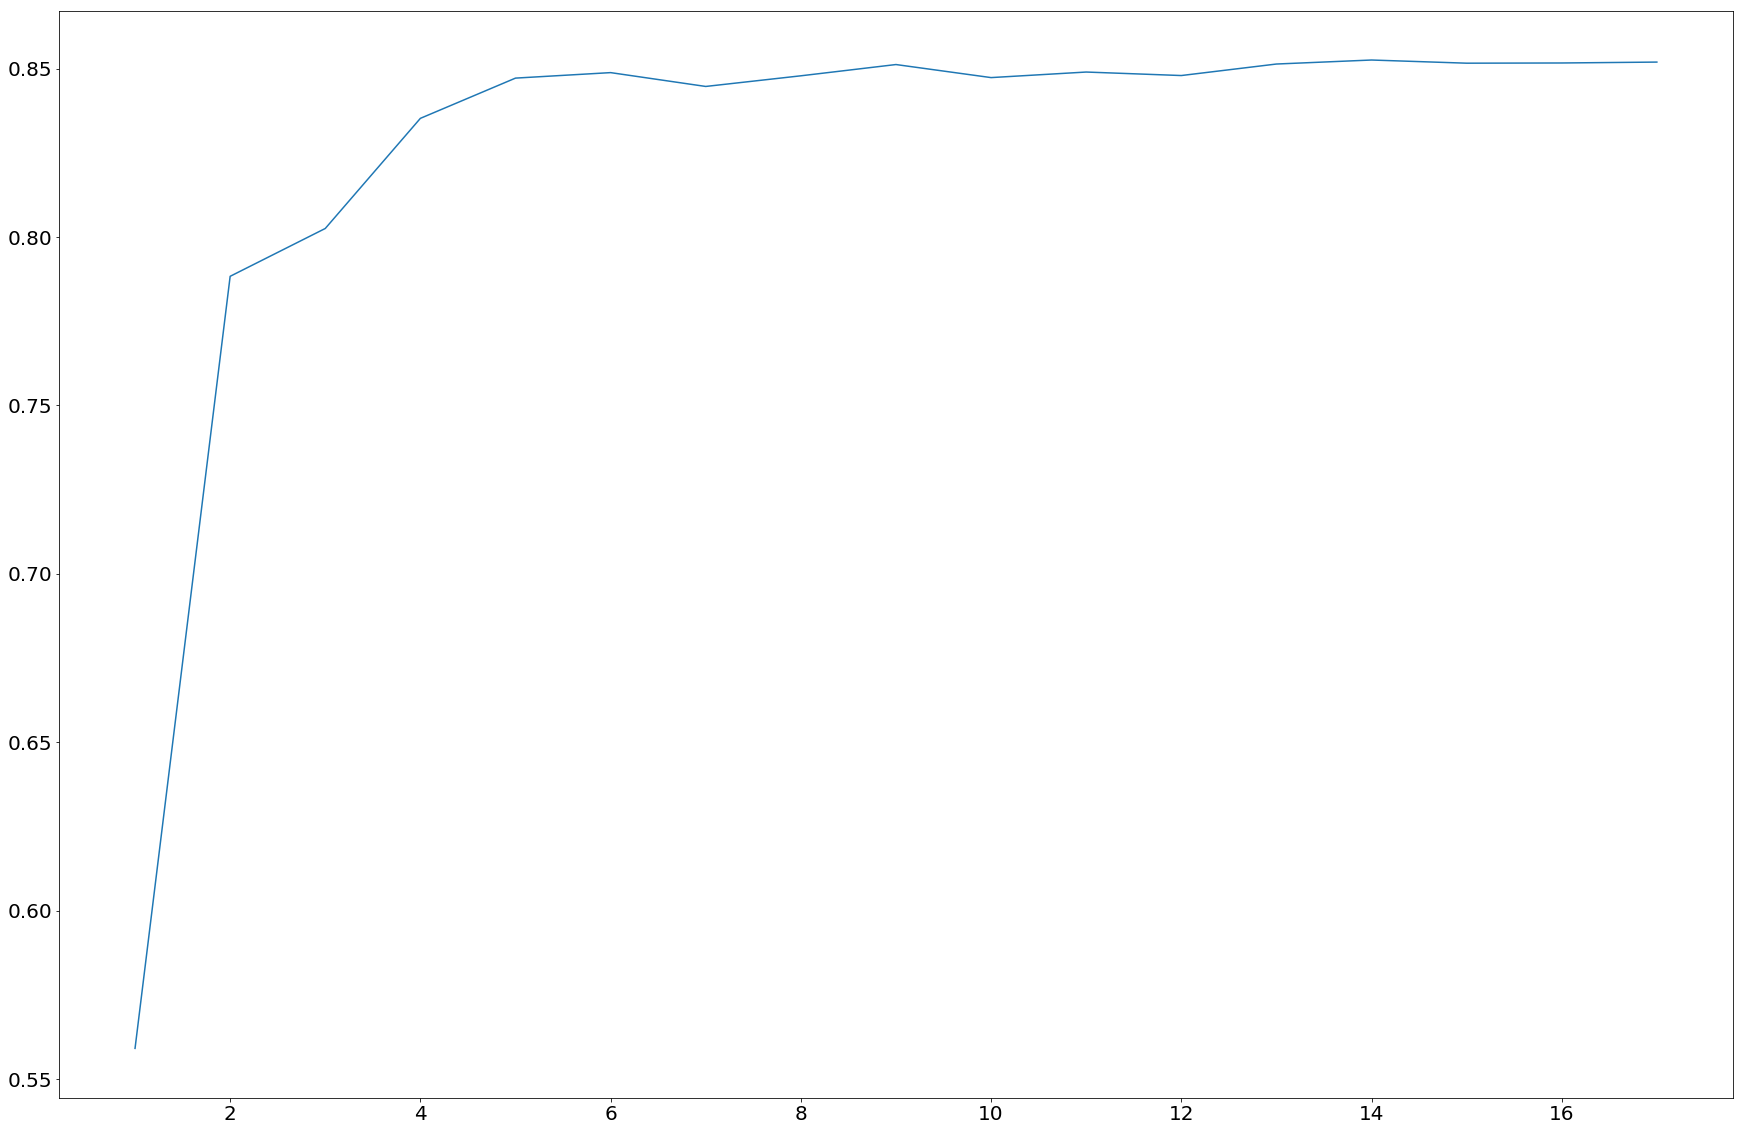

In [27]:
#plot graph showing the number of features which gives the maximum accuracy
plt.figure()
plt.plot(range(1,len(selector.grid_scores_)+1),selector.grid_scores_)
plt.show()

In [28]:
X_rfecv = dat[selected_features].values
X_train,X_test,y_train,y_test = train_test_split(X_rfecv,y,test_size=0.3,random_state=100)
log_reg.fit(X_train,y_train)
#predicting with models
predicts = log_reg.predict(X_test)
#f1 score is harmonic mean of recall and precision score
confusion_matrix(y_test,predicts)

/Users/emmanuels/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[85275,    26],
       [   47,    95]])

In [29]:
print(classification_report(y_test,predicts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.79      0.67      0.72       142

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.89      0.83      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled = scaler.fit_transform(a)

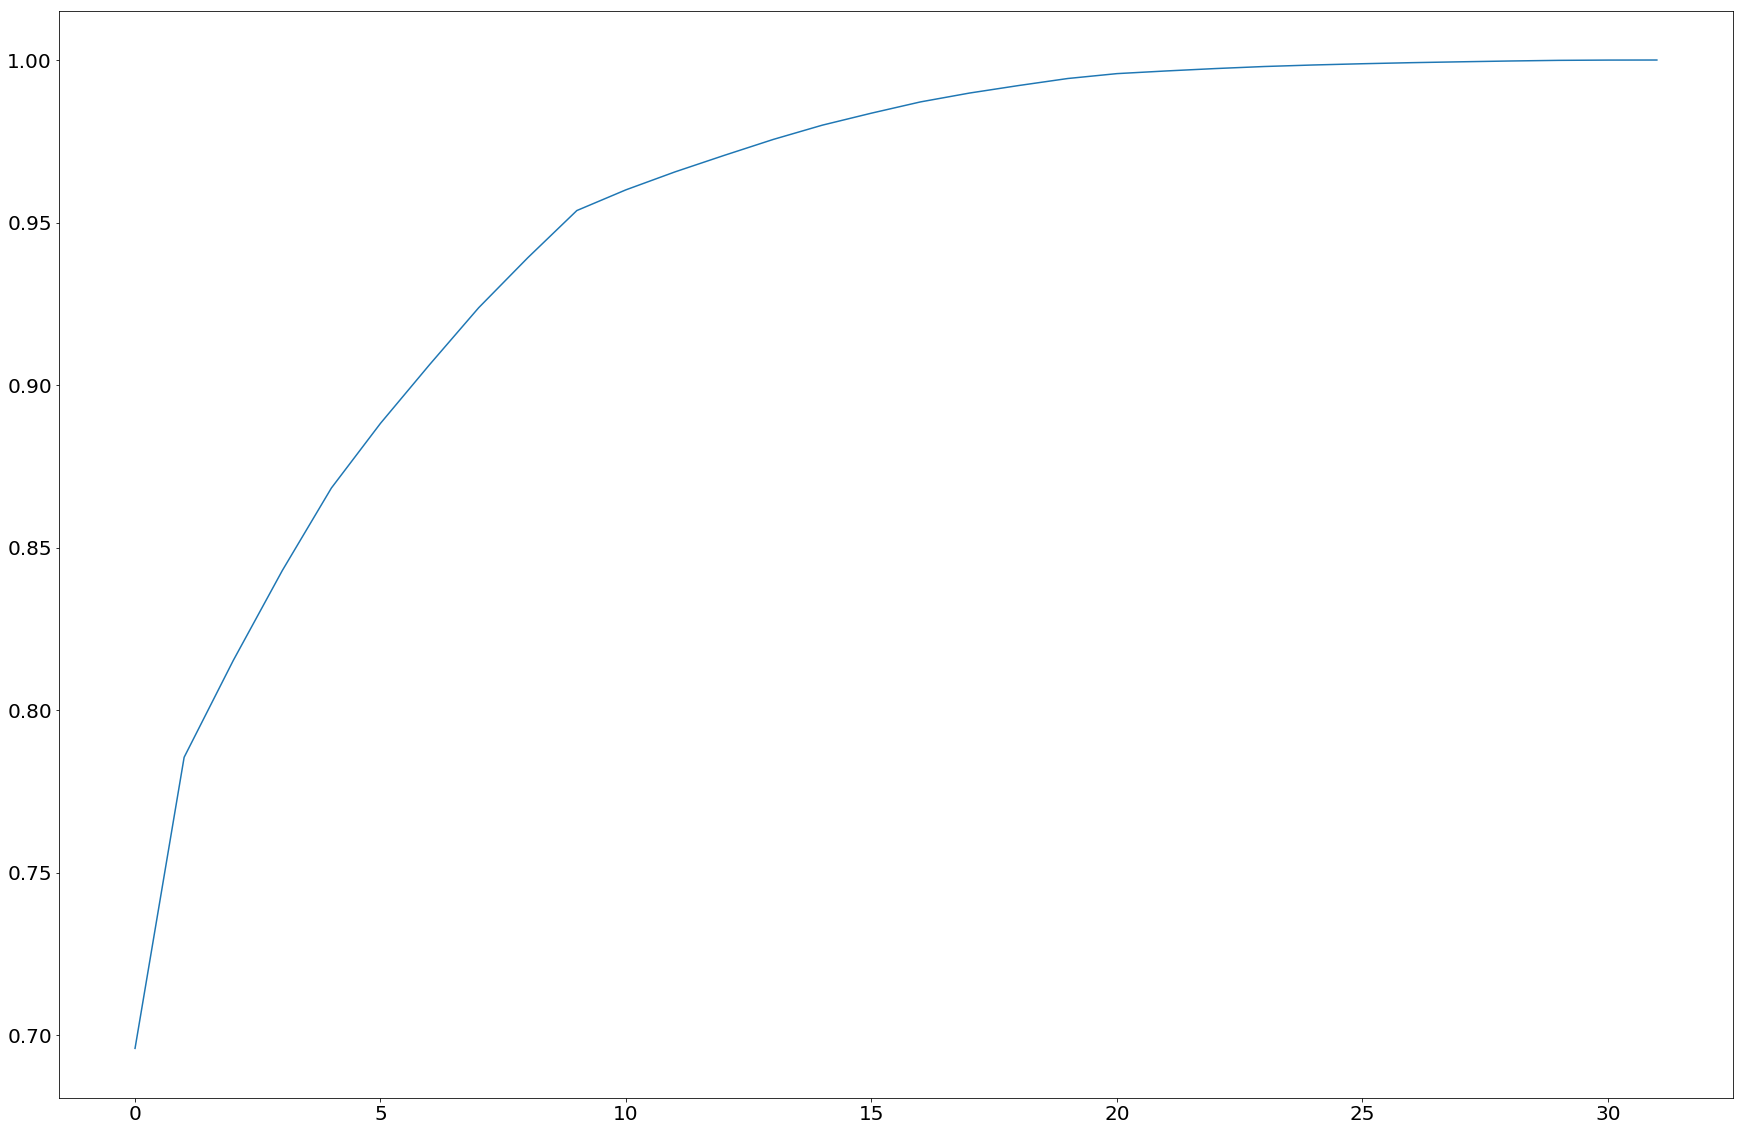

In [32]:
pca = PCA().fit(rescaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [33]:
pca = PCA(n_components=2)
dataset = pca.fit_transform(rescaled)

In [34]:
X_train,X_test,y_train,y_test = train_test_split(dataset,y,test_size=0.3,random_state=100)

In [35]:
log_reg.fit(X_train,y_train)
predictions = log_reg.predict(X_test)

/Users/emmanuels/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [36]:
confusion_matrix(y_test,predictions)

array([[85301,     0],
       [  142,     0]])

In [37]:
!pip install xgboost

In [38]:
dat['Hours'] = dat['Hours'].astype(int)

In [39]:
#trying XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
y = dat['Class']
X = dat.drop(['Class'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=100)
xgb = XGBClassifier()
#fine tuning XGB parameters
params = {'min_child_weight':[5,15],
          'subsample':[0.6,0.8,1.0],
          'gamma':[1,5,10,15],
          'learning_rate': [0.01,0.05,0.1],
          'colsample_bytree':[0.6,0.8,1.0],
          'max_depth':[2,3,5,10],
          'n-estimaors': range(50,1000,50)
    }
#gridsearch
random_search = RandomizedSearchCV(xgb,params,cv=5,n_iter=5,scoring='f1',random_state=100)

In [40]:
#finding best parameters
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=None,
          param_distributions={'min_child_weight': [5, 15], 'subsample': [0.6, 0.8, 1.0], 'gamma': [1, 5, 10, 15], 'learning_rate': [0.01, 0.05, 0.1], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [2, 3, 5, 10], 'n-estimaors': range(50, 1000, 50)},
          pre_dispatch='2*n_jobs', random_state=100, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [41]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1.0, gamma=1,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n-estimaors=600, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1.0, verbosity=1)

In [42]:
opt_predicts = random_search.predict(X_test)

In [43]:
confusion_matrix(y_test,opt_predicts)

array([[85290,    11],
       [   31,   111]])

In [44]:
print(classification_report(y_test,opt_predicts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.91      0.78      0.84       142

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.95      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [464]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [10],
              "max_depth": range(20,200,20),
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": range(10,100,10),
              }
clf=RandomizedSearchCV(dtc,param_grid,cv=5,scoring='f1')
clf.fit(X_train,y_train)
clf_preds = clf.predict(X_test)
confusion_matrix(y_test,clf_preds)

array([[85281,    20],
       [   35,   107]])

In [465]:
clf.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_leaf_nodes': 20,
 'max_depth': 100,
 'criterion': 'gini'}

In [45]:
#fine tune random forest too
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
param_grid = {"criterion":['gini','entropy'],
             'n_estimators':range(20,200,20),
             'max_depth':range(20,200,20),
             }
tuned_rfc = RandomizedSearchCV(random_forest,param_grid,cv=5,scoring='f1')
tuned_rfc.fit(X_train,y_train)
tuned_preds = tuned_rfc.predict(X_test)
confusion_matrix(y_test,tuned_preds)

array([[85292,     9],
       [   36,   106]])

In [46]:
print(classification_report(y_test,tuned_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.92      0.75      0.82       142

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.96      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [468]:
from sklearn.ensemble import VotingClassifier
X = dat.drop(['Class'],axis=1)
voting_class = VotingClassifier(estimators=[('tuned_decision',clf),
                                            ('tuned_random',tuned_rfc)],voting='hard')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=100)
voting_class.fit(X_train,y_train)
y_pred = voting_class.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[85293,     8],
       [   45,    97]])

In [67]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10,shuffle=True,random_state=0)
#running 10 fold cross validation and returning scores in list
scores = []
for train_index, test_index in kfold.split(X,y):
  print("Train Index:", train_index, "\n")
  print("Test Index:", test_index)
  X_train,X_test = X.iloc[train_index], X.iloc[test_index]


Train Index: [     0      1      2 ... 284804 284805 284806] 

Test Index: [    14     28     29 ... 284789 284797 284802]
Train Index: [     0      1      2 ... 284803 284804 284806] 

Test Index: [    57     65     89 ... 284785 284791 284805]
Train Index: [     1      3      4 ... 284803 284805 284806] 

Test Index: [     0      2      5 ... 284794 284795 284804]
Train Index: [     0      1      2 ... 284804 284805 284806] 

Test Index: [     8     12     16 ... 284779 284788 284796]
Train Index: [     0      1      2 ... 284804 284805 284806] 

Test Index: [    24     31     41 ... 284775 284781 284790]
Train Index: [     0      1      2 ... 284804 284805 284806] 

Test Index: [     6     19     26 ... 284771 284772 284803]
Train Index: [     0      1      2 ... 284803 284804 284805] 

Test Index: [     3      7      9 ... 284784 284792 284806]
Train Index: [     0      2      3 ... 284804 284805 284806] 

Test Index: [     1     11     22 ... 284798 284799 284800]
Train Index: [  

In [75]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
strat = StratifiedKFold(n_splits=5, shuffle=True)
strat.get_n_splits(X)
model_score = []
for train_index, test_index in strat.split(X,y):
    X_train,X_test,y_train,y_test = X.iloc[train_index], X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
    random_search.fit(X_train, y_train)
    xgb_predicts=random_search.predict(X_test)
    model_score.append(f1_score(y_test,xgb_predicts,average='macro',labels=np.unique(xgb_predicts)))

In [76]:
scores_table = pd.DataFrame({"F1 Score" :model_score})
scores_table

,F1 Score
0,0.919223
1,0.931713
2,0.937403
3,0.917952
4,0.926908
